In [ ]:
import pandas as pd
import numpy as np
import re 
import nltk 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold


from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')
import matplotlib.patches as mpatches

In [ ]:
df_train = pd.read_csv('Corona_NLP_train.csv' , encoding = 'latin_1')
df_val = pd.read_csv('Corona_NLP_test.csv' , encoding = 'latin_1')

In [ ]:
df_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
df_val.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [ ]:
training = df_train.copy()
validation = df_val.copy()

In [ ]:
training = training[['OriginalTweet', 'Sentiment']]
validation = validation[['OriginalTweet', 'Sentiment']]

In [ ]:
training.isnull().sum()

OriginalTweet    0
Sentiment        0
dtype: int64

In [ ]:
validation.isnull().sum()

OriginalTweet    0
Sentiment        0
dtype: int64

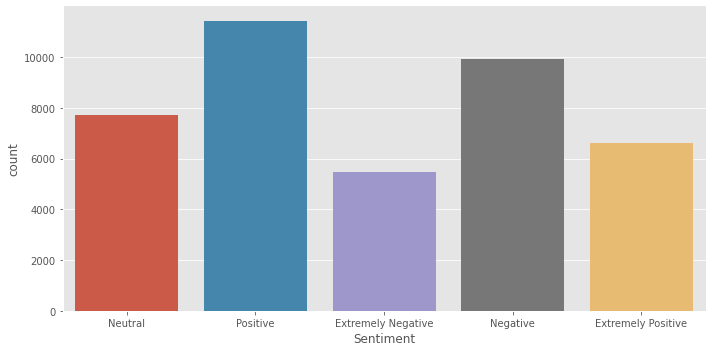

In [ ]:
sns.catplot(x = 'Sentiment', kind = 'count', data = training, height = 5, aspect = 2)

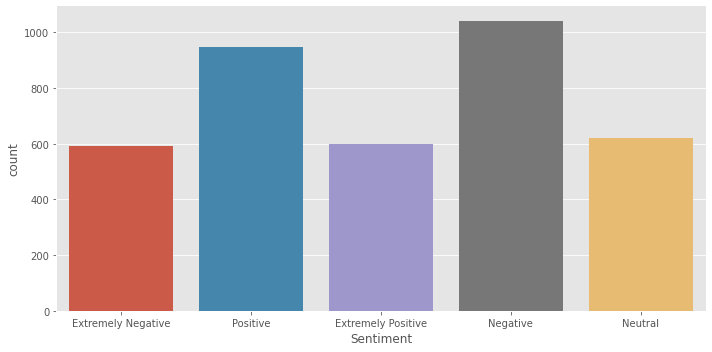

In [ ]:
sns.catplot(x = 'Sentiment', kind = 'count', data = validation, height = 5, aspect = 2)

In [ ]:
training['text'] = training.OriginalTweet
training["text"] = training["text"].astype(str)

validation['text'] = validation.OriginalTweet
validation["text"] = validation["text"].astype(str)

# Data has 5 classes, let's convert them to 3

def classes_def(x):
    if x ==  "Extremely Positive":
        return "2"
    elif x == "Extremely Negative":
        return "0"
    elif x == "Negative":
        return "0"
    elif x ==  "Positive":
        return "2"
    else:
        return "1"
    

training['label']=training['Sentiment'].apply(lambda x:classes_def(x))
validation['label']=validation['Sentiment'].apply(lambda x:classes_def(x))


training.label.value_counts(normalize= True)

2    0.438467
0    0.374128
1    0.187404
Name: label, dtype: float64

In [ ]:
#Remove Urls and HTML links
def remove_urls(text):
    url_remove = re.compile(r'https?://\S+|www\.\S+')
    return url_remove.sub(r'', text)
    
training['text_new']=training['text'].apply(lambda x:remove_urls(x))
validation['text_new']=validation['text'].apply(lambda x:remove_urls(x))

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
training['text']=training['text_new'].apply(lambda x:remove_html(x))
validation['text']=validation['text_new'].apply(lambda x:remove_html(x))

In [ ]:
# Lower casing
def lower(text):
    low_text= text.lower()
    return low_text
training['text_new']=training['text'].apply(lambda x:lower(x))
validation['text_new']=validation['text'].apply(lambda x:lower(x))


# Number removal
def remove_num(text):
    remove= re.sub(r'\d+', '', text)
    return remove
training['text']=training['text_new'].apply(lambda x:remove_num(x))
validation['text']=validation['text_new'].apply(lambda x:remove_num(x))

In [ ]:
#Remove stopwords & Punctuations
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
",".join(stopwords.words('english'))
STOPWORDS = set(stopwords.words('english'))

def punct_remove(text):
    punct = re.sub(r"[^\w\s\d]","", text)
    return punct

training['text_new']=training['text'].apply(lambda x:punct_remove(x))
validation['text_new']=validation['text'].apply(lambda x:punct_remove(x))


def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

training['text']=training['text_new'].apply(lambda x:remove_stopwords(x))
validation['text']=validation['text_new'].apply(lambda x:remove_stopwords(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#Remove mentions and hashtags
def remove_mention(x):
    text=re.sub(r'@\w+','',x)
    return text
training['text_new']=training['text'].apply(lambda x:remove_mention(x))
validation['text_new']=validation['text'].apply(lambda x:remove_mention(x))

def remove_hash(x):
    text=re.sub(r'#\w+','',x)
    return text
training['text']=training['text_new'].apply(lambda x:remove_hash(x))
validation['text']=validation['text_new'].apply(lambda x:remove_hash(x))

#Remove extra white space left while removing stuff
def remove_space(text):
    space_remove = re.sub(r"\s+"," ",text).strip()
    return space_remove
training['text_new']=training['text'].apply(lambda x:remove_space(x))
validation['text_new']=validation['text'].apply(lambda x:remove_space(x))
validation = validation.drop(columns=['text_new'])
training = training.drop(columns=['text_new'])

In [ ]:
training['OriginalTweet'] = training['OriginalTweet'].str.replace(r'http\S+', '', regex = True)
training['OriginalTweet'] = training['OriginalTweet'].str.replace(r'@\S+', '', regex = True)
validation['OriginalTweet'] = validation['OriginalTweet'].str.replace(r'http\S+', '', regex = True)
validation['OriginalTweet'] = validation['OriginalTweet'].str.replace(r'@\S+', '', regex = True)
print(training['OriginalTweet'])

0                                                and  and 
1        advice Talk to your neighbours family to excha...
2        Coronavirus Australia: Woolworths to give elde...
3        My food stock is not the only one which is emp...
4        Me, ready to go at supermarket during the #COV...
                               ...                        
41152    Airline pilots offering to stock supermarket s...
41153    Response to complaint not provided citing COVI...
41154    You know itÂs getting tough when   is rationi...
41155    Is it wrong that the smell of hand sanitizer i...
41156     Well new/used Rift S are going for $700.00 on...
Name: OriginalTweet, Length: 41157, dtype: object


In [ ]:
stop_words = ['a', 'and', 'the', 'i', 'me', 'my', 'we', 'ours', 'he', 'his', 'her', 'what', 'am', 'have', 'has', 'had', 'be', 'was', 'been', 'of', 'at', 'for', 'to', 'your', 'is']

# Basic cleansing
def cleansing(text):
    # Tokenize
    tokens = text.split(' ')
    # Lower case
    tokens = [w.lower() for w in tokens]
    # Remove stop words
    tokens = [w for w in tokens if w not in stop_words]
    return ' '.join(tokens)

# All-in-one preproce
def preprocess_x(x):
    processed_x = [cleansing(text) for text in x]
    
    return processed_x

training['text_new']=training['text'].apply(lambda x:preprocess_x(x))
validation['text_new']=validation['text'].apply(lambda x:preprocess_x(x))

In [ ]:
print(training.shape)
training = training[(training['OriginalTweet'].str.len() > 20)]
print(training.shape)

(41157, 5)
(41078, 5)


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_tok = '<OOV>'

training_sentences = training['OriginalTweet']
training_labels = training['Sentiment']

validation_sentences = validation['OriginalTweet']
validation_labels = validation['Sentiment']

tokenizer = Tokenizer(oov_token = oov_tok, num_words = 6000)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
vocab_size = len(word_index) +1

sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen = max_length, truncating = trunc_type)

train_labels = tokenizer.texts_to_sequences(training_labels)
train_padded = pad_sequences(training_labels, maxlen= max_length, truncating= trunc_type)


validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen = max_length, truncating = trunc_type)

ValueError: ignored

In [ ]:
train_labels = tokenizer.texts_to_sequences(training_labels)
train_padded = pad_sequences(training_labels, maxlen= max_length, truncating= trunc_type)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 5, restore_best_weights = True)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Conv1D(128, 5, activation = 'relu'),
    tf.keras.layers.MaxPooling1D(pool_size = 1),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv1D(256, 5, activation = 'relu'),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(3, activation = 'softmax')
])
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

In [ ]:
history = model.fit(padded, 
                    np.array(training_labels), 
                    epochs = 20)

In [ ]:
training_labels.dtypes

In [ ]:
loss = history.history['loss']
acc = history.history['accuracy']

val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Loss')
plt.legend()

plt.figure()

plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.title('Accuracy Plot')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Accuarcy')

In [ ]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 64, input_length = max_length),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv1D(128, 5, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(256, 5, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(512, 5, activation = 'relu'),
    tf.keras.layers.MaxPooling1D(pool_size = 4),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(3, activation = 'softmax')
])
model_2.summary()